In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set the image size and other parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

# Define the paths for training and validation directories
train_directory = '/kaggle/input/datasetnetwork11/datasetnetwork1test/train'
valid_directory = '/kaggle/input/datasetnetwork11/datasetnetwork1test/test'

# Load and preprocess the data (no pre-processing, just loading)
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    return image

# Load images from the "No-DR" class
train_data = []
train_labels = []
no_dr_path = os.path.join(train_directory, "0")
for filename in os.listdir(no_dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(no_dr_path, filename)
        image = load_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(0)

# Load images from the "DR" class
dr_path = os.path.join(train_directory, "1")
for filename in os.listdir(dr_path):
    if filename.endswith((".jpeg", ".jpg")):
        image_path = os.path.join(dr_path, filename)
        image = load_image(image_path)
        if image is not None:
            train_data.append(image)
            train_labels.append(1)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# One-hot encode the labels
train_labels = to_categorical(train_labels)

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the MobileNetV2 model (excluding the top fully-connected layers)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Freeze the base model layers
base_model.trainable = False

# Create the model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])


# Define callbacks for early stopping, model checkpoint, and reduce on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/updated/network1best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [3]:
# Load the saved model weights
#model.load_weights('/kaggle/working/updated/best_model.h5')

# Train the model
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=EPOCHS,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])



Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9718
Epoch 1: val_loss improved from inf to 0.00685, saving model to /kaggle/working/updated/network1best_model.h5
140/140 [==============================] - 21s 72ms/step - loss: 0.1046 - accuracy: 0.9718 - val_loss: 0.0069 - val_accuracy: 0.9982 - lr: 1.0000e-04
Epoch 2/50
140/140 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980
Epoch 2: val_loss improved from 0.00685 to 0.00303, saving model to /kaggle/working/updated/network1best_model.h5
140/140 [==============================] - 7s 49ms/step - loss: 0.0119 - accuracy: 0.9980 - val_loss: 0.0030 - val_accuracy: 0.9982 - lr: 1.0000e-04
Epoch 3/50
139/140 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9996
Epoch 3: val_loss improved from 0.00303 to 0.00190, saving model to /kaggle/working/updated/network1best_model.h5
140/140 [==============================] - 7s 49ms/step - loss: 0.0055 - ac

35/35 [==============================] - 1s 37ms/step - loss: 4.8097e-05 - accuracy: 1.0000
Validation loss: 4.809738675248809e-05
Validation accuracy: 1.0


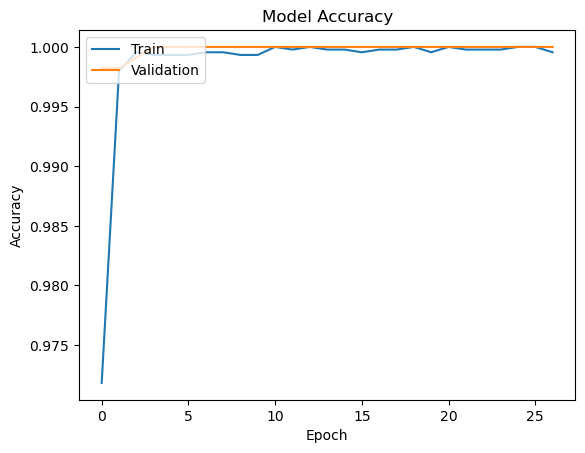

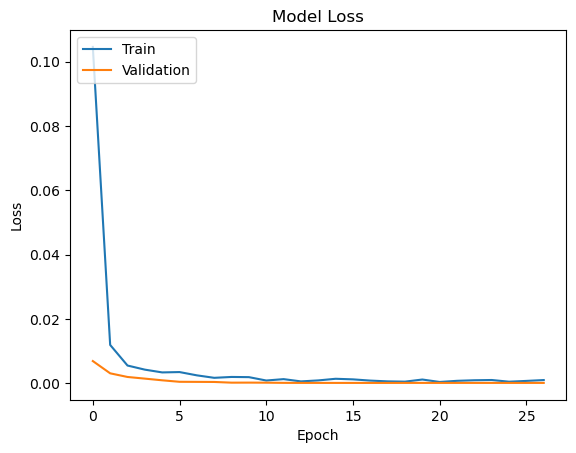

In [4]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data, val_labels)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [5]:
# Make predictions on the validation dataset
predictions = model.predict(val_data)
y_pred = np.argmax(predictions, axis=1)

# Compute precision, recall, accuracy, and F1 score for each class
precision = precision_score(np.argmax(val_labels, axis=1), y_pred, average=None)
recall = recall_score(np.argmax(val_labels, axis=1), y_pred, average=None)
f1 = f1_score(np.argmax(val_labels, axis=1), y_pred, average=None)
accuracy = accuracy_score(np.argmax(val_labels, axis=1), y_pred)

# Display the metrics for each class
class_labels = ['0', '1']  # Update with your class labels

for i, class_label in enumerate(class_labels):
    print(f'Class: {class_label}')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1 Score: {f1[i]}')
    print('---')

# Display overall accuracy
print('Overall Accuracy:', accuracy)


35/35 [==============================] - 2s 33ms/step
Class: 0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
---
Class: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
---
Overall Accuracy: 1.0


In [3]:
import numpy as np
from PIL import Image
from keras.models import load_model
image_width = 224
image_height = 224
# Load the saved model
model = load_model('/kaggle/input/network1bestmodel/network1best_model (4).h5')

# Load and preprocess the image
image_path = '/kaggle/input/iamge12/WIN_20230707_13_11_11_Pro.jpg'
image = Image.open(image_path)
image = image.resize((image_width, image_height))  # Adjust the size according to your model's input shape
image = np.array(image)
image = image / 255.0  # Normalize the image data

# Perform the prediction
predictions = model.predict(np.expand_dims(image, axis=0))
predicted_label = np.argmax(predictions[0])

# Print the predicted label
if predicted_label == 0:
    print("Predicted label: non-retinal")
elif predicted_label == 1:
    print("Predicted label: retinal")
else:
    print("Invalid label predicted")


1/1 [==============================] - 1s 750ms/step
Predicted label: non-retinal
